# 1- Extracting data from the HWSD2 itself

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
with rasterio.open("src/HWSD2.bil") as src:
    hwsd2_data = src.read(1)
    hwsd2_data = hwsd2_data[4500:6000, 20500:23000]

    original_transform = src.transform
    # as data is cropped, we need to update the transform
    cropped_transform = original_transform * rasterio.Affine.translation(20500, 4500)

    height = hwsd2_data.shape[0]
    width = hwsd2_data.shape[1]
    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xs, ys = rasterio.transform.xy(cropped_transform, rows, cols)
    lons= np.array(xs)
    lats = np.array(ys)
    

In [3]:
original_transform

Affine(0.00833333333333333, 0.0, -179.99999999999966,
       0.0, -0.00833333333333333, 89.99999999999996)

In [4]:
df = pd.DataFrame({"lon": lons.flatten(), "lat": lats.flatten(), "SMU": hwsd2_data.flatten()})

In [5]:
print(df.shape)
df.head()

(3750000, 3)


,lon,lat,SMU
0,-9.162500,52.495833,10326
1,-9.154167,52.495833,10326
2,-9.145833,52.495833,10326
3,-9.137500,52.495833,10326
4,-9.129167,52.495833,10326


In [6]:
df.loc[df["SMU"] == 65535, "SMU"] = np.nan

In [7]:
df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["lon"], df["lat"]), crs="EPSG:4326")

### As the yield data of AGRESTE is available at the department level, we aim to asignate a department to each HWSDB point

In [8]:
depts = gpd.read_file("src/contour-des-departements.geojson")

In [9]:
depts.head()

,code,nom,geometry
0,01,Ain,"POLYGON ((4.78021 46.17668, 4.78024 46.18905, ..."
1,02,Aisne,"POLYGON ((3.17296 50.01131, 3.17382 50.01186, ..."
2,03,Allier,"POLYGON ((3.03207 46.79491, 3.03424 46.7908, 3..."
3,04,Alpes-de-Haute-Provence,"POLYGON ((5.67604 44.19143, 5.67817 44.19051, ..."
4,05,Hautes-Alpes,"POLYGON ((6.26057 45.12685, 6.26417 45.12641, ..."


In [10]:
# Put all the geometry in a polygon format
multi = depts[depts.geometry.type == 'MultiPolygon']
single = depts[depts.geometry.type == 'Polygon']

depts = pd.concat([single, multi.explode(index_parts=True).reset_index(drop=True)])

In [11]:
depts.geometry.type.unique()

array(['Polygon'], dtype=object)

In [12]:
# Assigning a department to each point comming from the Harmonized World Soil Database grid.
# Perform spatial join
df = gpd.sjoin(df, depts[['geometry', 'code']], how='left', predicate='within')
# Rename the joined column for clarity
df = df.rename(columns={'code': 'dept'})
df.drop(columns=['index_right', 'geometry'], inplace=True)

In [13]:
# Deleting every point that is not in a French department.
df.dropna(subset=['dept'], inplace=True)

<Axes: xlabel='lon', ylabel='lat'>

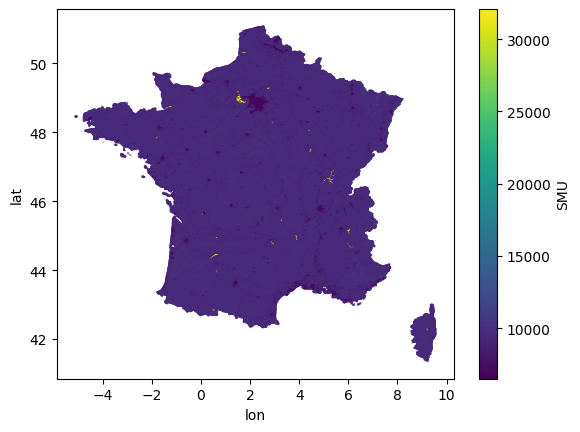

In [14]:
df.plot(kind="scatter", x="lon", y="lat", c="SMU", cmap="viridis", s=0.01)

In [15]:
df.groupby("dept").agg({"SMU": pd.Series.nunique}).sort_values("SMU", ascending=False)

,SMU
dept,
01,35
24,35
66,30
64,27
68,27
...,...
2A,9
93,4
94,3


In [16]:
print(df.shape)
df.head()

(928362, 4)


,lon,lat,SMU,dept
423905,2.545833,51.087500,9364.0,59
426402,2.520833,51.079167,9413.0,59
426403,2.529167,51.079167,9413.0,59
426404,2.537500,51.079167,9413.0,59
426405,2.545833,51.079167,9413.0,59


In [17]:
import pandas_access as mdb

db_filename = 'src/HWSD2.mdb'

# Listing the tables.
for tbl in mdb.list_tables(db_filename):
  print(tbl)

D_ADD_PROP
D_AWC
D_COVERAGE
D_FAO90
D_IL
D_KOPPEN
D_PHASE
D_ROOT_DEPTH
D_ROOTS
D_TEXTURE
D_TEXTURE_SOTER
D_TEXTURE_USDA
D_WRB_PHASES
D_WRB2
D_WRB4
HWSD2_LAYERS
HWSD2_LAYERS_METADATA
HWSD2_SMU
HWSD2_SMU_METADATA
WRB_Class
WRB_Layer
WRB_Library
D_DRAINAGE
D_SWR
D_WRB2code


In [18]:
df_smu = mdb.read_table(db_filename, "HWSD2_SMU")

In [19]:
print(df_smu.shape)
df_smu.head()

(29538, 23)


,ID,HWSD2_SMU_ID,WISE30s_SMU_ID,HWSD1_SMU_ID,COVERAGE,SHARE,WRB4,WRB_PHASES,WRB2,WRB2_CODE,...,REF_BULK_DENSITY,BULK_DENSITY,DRAINAGE,ROOT_DEPTH,AWC,PHASE1,PHASE2,ROOTS,IL,ADD_PROP
0,669,12707,WD10012707,12707,3,40,ALfr,ALfr,AL,2,...,1.63,1.35,MW,1,168,NaN,NaN,NaN,NaN,0.0
1,695,11825,WD30011825,11825,2,100,ALfr,ALfr,AL,2,...,1.76,1.4400001,MW,1,152,NaN,NaN,NaN,NaN,0.0
2,696,11823,WD30011823,11823,2,100,ALfr,ALfr,AL,2,...,1.76,1.4400001,MW,1,152,NaN,NaN,NaN,NaN,0.0
3,697,13458,WD30013458,13458,3,100,ALfr,ALfr,AL,2,...,1.76,1.4400001,MW,1,152,NaN,NaN,NaN,NaN,0.0
4,698,11824,WD30011824,11824,2,100,ALfr,ALfr,AL,2,...,1.76,1.4400001,MW,1,152,NaN,NaN,NaN,NaN,0.0


In [20]:
df_smu.dtypes

ID                    int64
HWSD2_SMU_ID          int64
WISE30s_SMU_ID       object
HWSD1_SMU_ID          int64
COVERAGE             object
SHARE                object
WRB4                 object
WRB_PHASES           object
WRB2                 object
WRB2_CODE            object
FAO90                object
KOPPEN               object
TEXTURE_USDA         object
REF_BULK_DENSITY     object
BULK_DENSITY         object
DRAINAGE             object
ROOT_DEPTH            int64
AWC                   int64
PHASE1               object
PHASE2               object
ROOTS                object
IL                   object
ADD_PROP            float64
dtype: object

In [21]:
"""in this table we can found all the soil layers associated to each SMU
(1 SMU can have multiple soils ID realted to it in multiple layers)"""

df_layers = mdb.read_table(db_filename, "HWSD2_LAYERS", dtype={"ROOT_DEPTH": object, "SWR": object,
                                                               "AWC": object,"ADD_PROP" : object,
                                                               }
                           )


In [22]:
df_layers.head()

,ID,HWSD2_SMU_ID,NSC_MU_SOURCE1,NSC_MU_SOURCE2,WISE30s_SMU_ID,HWSD1_SMU_ID,COVERAGE,SEQUENCE,SHARE,NSC,...,CEC_SOIL,CEC_CLAY,CEC_EFF,TEB,BSAT,ALUM_SAT,ESP,TCARBON_EQ,GYPSUM,ELEC_COND
0,1,1666,NaN,NaN,WD10001666,1666,4,1,70,NaN,...,8,50,4,5,71,0,4,0,2.9000001,1
1,2,6309,NaN,NaN,WD10006309,6309,4,1,50,NaN,...,8,50,4,5,71,0,4,0,2.9000001,1
2,3,1700,NaN,NaN,WD10001700,1700,4,1,60,NaN,...,8,50,4,5,71,0,4,0,2.9000001,1
3,4,6310,NaN,NaN,WD10006310,6310,4,1,30,NaN,...,8,50,4,5,71,0,4,0,2.9000001,1
4,5,6311,NaN,NaN,WD10006311,6311,4,1,50,NaN,...,8,50,4,5,71,0,4,0,2.9000001,1


In [23]:
df_layers.dtypes

ID                 int64
HWSD2_SMU_ID       int64
NSC_MU_SOURCE1    object
NSC_MU_SOURCE2    object
WISE30s_SMU_ID    object
HWSD1_SMU_ID       int64
COVERAGE          object
SEQUENCE          object
SHARE             object
NSC               object
WRB_PHASES        object
WRB4              object
WRB2              object
FAO90             object
ROOT_DEPTH        object
PHASE1            object
PHASE2            object
ROOTS             object
IL                object
SWR               object
DRAINAGE          object
AWC               object
ADD_PROP          object
LAYER             object
TOPDEP            object
BOTDEP            object
COARSE            object
SAND              object
SILT              object
CLAY              object
TEXTURE_USDA      object
TEXTURE_SOTER     object
BULK              object
REF_BULK          object
ORG_CARBON        object
PH_WATER          object
TOTAL_N           object
CN_RATIO          object
CEC_SOIL          object
CEC_CLAY          object


In [26]:
# TODO: Choose the relevant columns